# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [1]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
#from sklearn.svm import LinearSVC
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFE
#from sklearn.metrics import accuracy_score
#from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
#from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
#import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [30]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

#List of files to run over
filelist = ['DummyBVS1.csv','DummyBVS2.csv','DummyBVS3.csv','DummyBVS4.csv', 'DummyBVS5.csv']
    
#List of sleep threshold quantiles    
#quantiles=[0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5]
quantiles=[0.4,0.425]

#List of minimum lnegth for keeping state changes
#lengths=[25,27.5,30,32.5,35,37.5,40,42.5,45,47.5,50]
lengths=[40]

#Creates classes and dict holding all data for the analysis
def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        #Only creates MET MVA, VigPA and Sedendary columns
        d[idx].get_METS()
        #Labels sleep - SRI adds a considerable amount of time - so if you don't use it, change take_SRI to False
        d[idx].label_sleep(q_sleep=quantiles, bed_time = '21:00',wake_time = '20:59', lengths = lengths,
                           vol_threshold=5, take_SRI=False)
    return d

d = get_data(filelist)

#Processes the diary file - for the diary and data (d) dicts, indices are d[idx] = d[idx+1] - so for first subject select 
#d[0] and diary[1]
diaries = pd.read_csv('Data/dummydiaries.csv',index_col='id',header=0,dayfirst=True)
diaries_t = diaries.transpose().reset_index().rename(columns={'index':'var'}).drop([0,1])
diary = defaultdict(dict)
for idx in range(5):
    diary[idx+1] = diaries_t['DummyBVS'+str(idx+1)].dropna()
    diary_sleep = [] 
    diary_wake = [] 
    for i in range(len(diary[idx+1])): 
        if i % 2: 
            diary_wake.append(diary[idx+1][i+2]) 
        else : 
            diary_sleep.append(diary[idx+1][i+2])
    diary[idx+1] = pd.DataFrame(data={'sleep_onset':pd.Series(pd.to_datetime(diary_sleep,dayfirst=True)),
                                      'sleep_offset':pd.Series(pd.to_datetime(diary_wake,dayfirst=True))})
    diary[idx+1]['TST'] = pd.to_datetime(diary[idx+1]['sleep_offset'],dayfirst=True) - pd.to_datetime(diary[idx+1]['sleep_onset'],dayfirst=True)
    diary[idx+1] = diary[idx+1].dropna()
    
#Creates a column of diary labels where sleep=1, wake=0 along the time series
def diary_annot(self, sleep_diary):
    self.data['diary_sleep'] = np.nan
    for timeon in sleep_diary['sleep_onset'].values:
        if (timeon in self.data['diary_sleep'].index.values):
            self.data['diary_sleep'].loc[timeon] = 1
    for timeoff in sleep_diary['sleep_offset'].values:
        if (timeoff in self.data['diary_sleep'].index.values):
            self.data['diary_sleep'].loc[timeoff] = 0
    self.data['diary_sleep'][0] = 0
    self.data['diary_sleep'] = self.data['diary_sleep'].fillna(method='ffill')
    self.data['diary_sleep'] = self.data['diary_sleep'].fillna(method='bfill')
    return self

for idx in d.keys():
    diary_annot(d[idx], diary[idx+1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


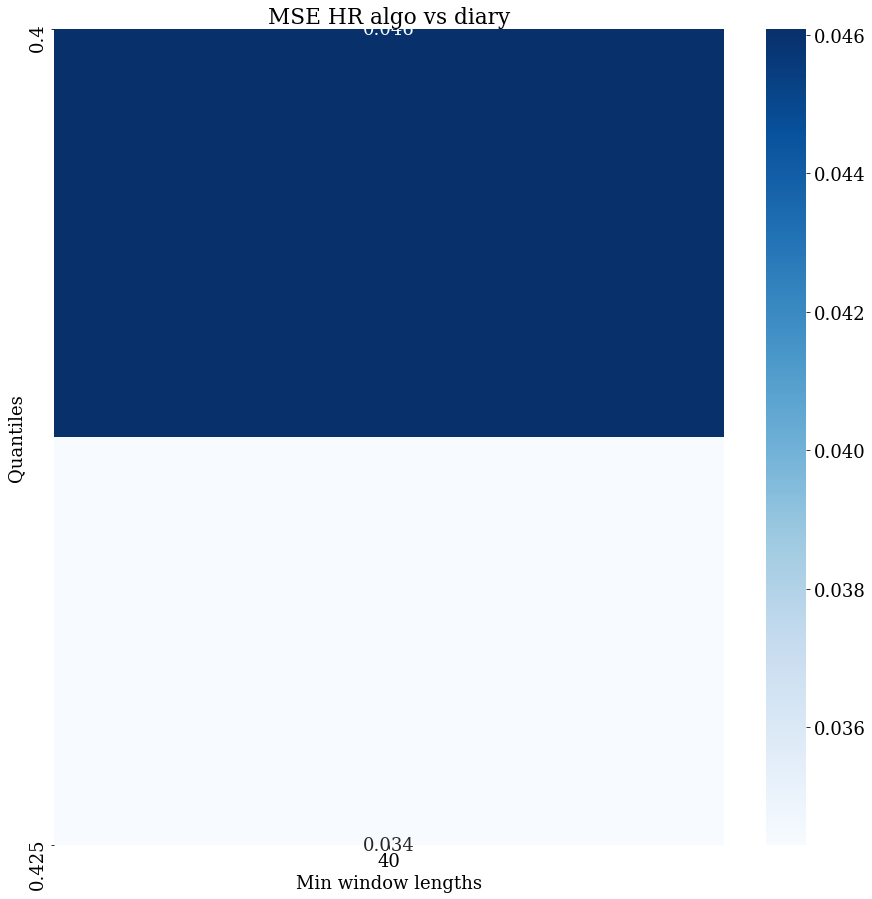

In [31]:
#Obtain MSE for the grid of parameters input to the label_sleep function
#I've removed the van hees references, check out the other optimisation notebooks if you plan to run that too, code can just be pasted in
#Main output is the df of average MSEs: 
def get_MSE(d, diary, plotting=True):

    from sklearn.metrics import mean_squared_error 

    mse = defaultdict(dict)
    zero_data = np.zeros(shape=(len(quantiles),len(lengths)))
    hrd_sum = pd.DataFrame(zero_data, columns=lengths, index=quantiles)

    for idx in d.keys():
        #Select only days when diary exists
        day_list = pd.to_datetime(diary[idx+1]['sleep_onset'].dt.date.unique().tolist())
        df_d = d[idx].data[day_list[0]:day_list[-1]+timedelta(hours=20)]
        hrd = pd.DataFrame()
        hrvh = pd.DataFrame()
        for qtl in quantiles:
            for lens in lengths:
                hrd.loc[qtl,lens] = mean_squared_error(df_d['diary_sleep'],
                                                       (df_d['sleep_window_'+str(qtl)+'_'+str(lens)]))
        mse[idx]['hrd'] = hrd
        hrd_sum = hrd_sum + hrd 
    
    hrd_mean = hrd_sum / len(d.keys())

    if plotting:
        rcParams['figure.figsize'] = 15,15
        f = sns.heatmap(hrd_mean, cmap="Blues",annot=True)
        f.set_ylabel('Quantiles')
        f.set_xlabel('Min window lengths')
        f.set_title('MSE HR algo vs diary')
        plt.show(f)
    return hrd_mean,f
    
MSE_df,f = get_MSE(d, diary, plotting=True)
    
#plt.savefig(f,'MSE.png',dpi=300)

In [57]:
#Housekeeping: explaining variables

#The optimal parameters for this population are:
best_len = MSE_df.idxmin(axis=1).min()
best_qtl = MSE_df.idxmin(axis=0).min()

print('Best minimum window length: ',best_len, ' mins')
print('Best threshold quantile: ',best_qtl)
print('Lowest MSE for the optimal parameters: ',np.round(MSE_df[best_len][best_qtl],4))

#All sleep windows and sleep quality measures, including the total duration of naps are available by calling:
#d[subject number].sleep_rec[quantile][min_length]
#print(d[0].sleep_rec[best_qtl][best_len])

#SRI, if you have used it, is available in the dict:
#d[subject_number].SRI[qauntile][min_length]
#print(d[0].SRI[best_qtl][best_len])

Best minimum window length:  40  mins
Best threshold quantile:  0.425
Lowest MSE for the optimal parameters:  0.0343


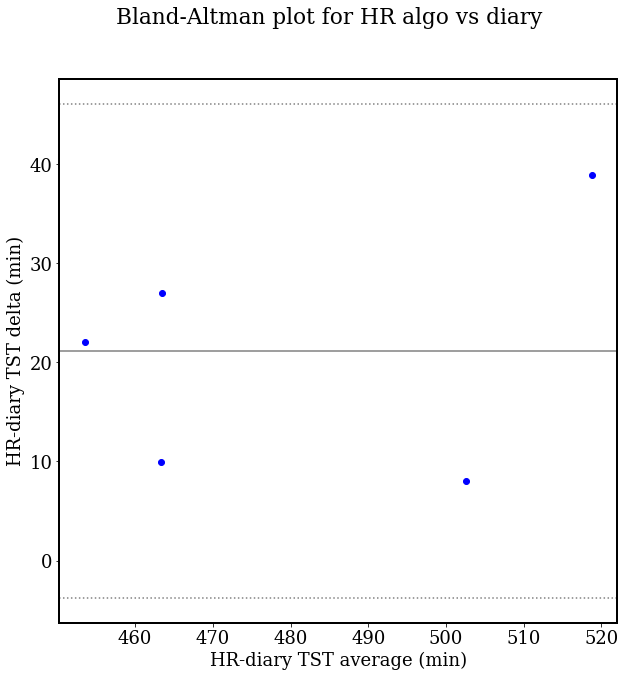

In [67]:
#Bland-Altman plots with the optimised HR algo parameters

def plot_bland_altman(d,diary, best_qtl = best_qtl, best_len=best_len, verbose=False):
    TST_avg = pd.DataFrame(columns=['hr','d','bax_hrd','bay_hrd'])
    for idx in d.keys():
        TST_avg.loc[idx,'hr'] = d[idx].sleep_rec[best_qtl][best_len]['TST'].astype('timedelta64[s]').mean()/60
        TST_avg.loc[idx,'d'] = diary[idx+1]['TST'].astype('timedelta64[s]').mean()/60
        TST_avg.loc[idx,'bax_hrd']=(TST_avg['hr'][idx] + TST_avg['d'][idx])/2
        TST_avg.loc[idx,'bay_hrd']=TST_avg['hr'][idx] - TST_avg['d'][idx]
    if verbose:
        print(TST_avg)

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.scatter(TST_avg['bax_hrd'],TST_avg['bay_hrd'],color='blue')
    ax.axhline(TST_avg['bay_hrd'].mean(),color='grey', label='Mean difference')
    ax.axhline(TST_avg['bay_hrd'].mean() - 1.96*TST_avg['bay_hrd'].std() ,color='grey', linestyle=':', label='Mean-1.96SD')
    ax.axhline(TST_avg['bay_hrd'].mean() + 1.96*TST_avg['bay_hrd'].std() ,color='grey', linestyle=':', label='Mean+1.96SD')
    ax.set_xlabel('HR-diary TST average (min)')
    ax.set_ylabel('HR-diary TST delta (min)')
    fig.suptitle('Bland-Altman plot for HR algo vs diary')
    plt.show(f)
    return fig

ba_plot = plot_bland_altman(d,diary,best_qtl, best_len)

#plt.savefig(ba_plot,'BlandAltmanPLot.png',dpi=300)

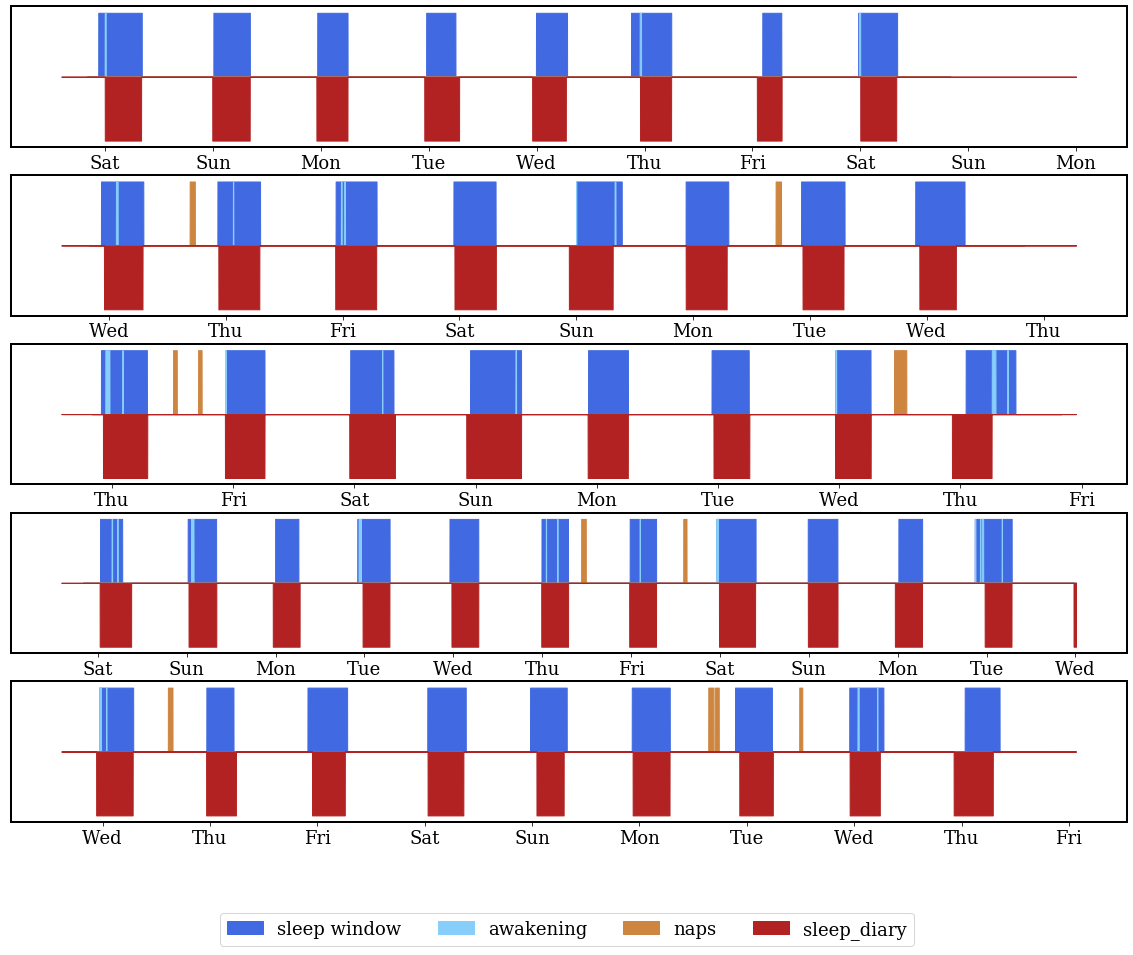

In [79]:
#Quick plot to check window alignment for N subjects
N = 5
string = str(best_qtl)+'_'+str(best_len)

fig,ax = plt.subplots(len(d.keys()),1,figsize=(20,15))
 
for jdx in range(N):
    day_list = pd.to_datetime(diary[jdx+1]['sleep_offset'].dt.date.unique().tolist())
    
    ax[jdx].fill_between(d[jdx].data[day_list[0]-timedelta(hours=4):day_list[-1]+timedelta(hours=20)].index, 0,
                         d[jdx].data[day_list[0]-timedelta(hours=4):day_list[-1]+timedelta(hours=20)]['sleep_window_'+string], 
                         color='royalblue',alpha=1, label='sleep window')
    
    ax[jdx].fill_between(d[jdx].data[day_list[0]-timedelta(hours=4):day_list[-1]+timedelta(hours=20)].index, 0,
                         d[jdx].data[day_list[0]-timedelta(hours=4):day_list[-1]+timedelta(hours=20)]['wake_window_'+string], 
                         color='lightskyblue',alpha=1, label='awakening')
    
    ax[jdx].fill_between(d[jdx].data[day_list[0]-timedelta(hours=4):day_list[-1]+timedelta(hours=20)].index, 0,
                         d[jdx].data[day_list[0]-timedelta(hours=4):day_list[-1]+timedelta(hours=20)]['naps_'+string],
                         color='peru',alpha=1, label='naps')
    ax[jdx].fill_between(d[jdx].data.index,0,d[jdx].data['diary_sleep']*(-1),color='firebrick', label='sleep_diary')
    ax[jdx].set_yticks([])
    ax[jdx].xaxis.set_major_locator(dates.DayLocator(interval=1))    # every day
    ax[jdx].xaxis.set_major_formatter(dates.DateFormatter('%a'))

handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels,ncol=5, loc='lower center')
fig.show()